# sandwich cluster analysis

See http://cvgmt.sns.it/paper/3120/

In [1]:
%matplotlib inline
from numpy import *
from math import atan2
import matplotlib.pyplot as plt
from matplotlib import patches

In [2]:
"""
helper functions to perform linear algebra on vectors
assume vectors are represented as array([x, y])
"""

def turn_left(v):
    x, y = v
    return array([-y, x])

def sqr(v):
    return (v**2).sum()

def arg(z):
    x, y = z
    return atan2(y, x)

def invert(xs, ys):
    """
    circular inversion
    """
    ms = xs**2 + ys**2
    return (xs/ms, ys/ms)

def invert_other(xs, ys):
    """
    circular inversion and symmetry with respect to x=0.5
    """
    ms = xs**2 + ys**2
    return (1-xs/ms, ys/ms)

def inverse_angle(z, angle):
    """
    direction of inverted curve
    suppose a curve has angle @angle at point @z. Compute the angle
    of the inverted curve at the inverted point.
    """
    return pi + 2*arg(z) - angle

def degrees(angle):
    return angle/pi*180

""" 
helper function used in drawings (not in computations!) 
"""

def my_arc(center, radius, start=0.0, end=2*pi):
    """ make a sampling of a circular arc """
    t = linspace(start, end, int(1+20*abs(radius*(end-start))))
    x, y = center
    return (x + radius*cos(t), y + radius*sin(t))

def my_line(start, end):
    return zip(start, end)

def my_points(*points):
    return [[p[0] for p in points], [p[1] for p in points]]



In [3]:
"""
define classes to represent (general) clusters
"""

class Edge(object):
    """
    A representation of an oriented circular arc (straight segments not tested yet!)
    """
    def __init__(self, start, end, direction):
        """ 
        create a circular arc starting from point @start in direction @direction 
        and ending in point @end
        """
        self.start = start
        self.end = end
        self.direction = direction 
        v = 0.5 * (end-start) # half oriented chord
        angle = arg(v) - direction 
        while angle > pi:
            angle -= 2*pi
        while angle <= -pi:
            angle += 2*pi
        self.angle = angle # signed angle between arc and chord
        self.center = 0.5*(start+end) + turn_left(v) / tan(angle) # center of circle
        absv = sqrt(sqr(v))
        self.l = 2 * absv # length of chord
        if angle >= 0:
            self.radius = absv / sin(angle)  # radius 
            self.alpha = arg(v) - pi/2 - angle  # start angle
            self.beta = self.alpha + 2*angle    # end angle
        else:
            self.radius = -absv / sin(angle)
            self.alpha = arg(v) + pi/2 - angle
            self.beta = self.alpha + 2*angle
        self.end_direction = direction + 2*angle  # direction of arc in end point
        
    def draw(self, plt, *args, **kwargs):
        plt.plot(*my_arc(self.center, self.radius, self.alpha, self.beta), *args, **kwargs)
        
    def length(self):
        return self.radius * 2 * abs(self.angle)
    
    def lunette_area(self):
        return self.angle * self.radius**2 - self.radius**2 * sin(self.angle) * cos(self.angle)
    
    def trapezoid_area(self):
        x0, y0 = self.start
        x1, y1 = self.end
        return 0.5*(y0 + y1)*(x0 - x1)
    
    def curved_trapezoid_area(self):
        return self.lunette_area() + self.trapezoid_area()
        
class Cluster(object):
    """ represent a general cluster """
    
    def __init__(self):
        self.vertices = [] # list of coordinates of vertices
        self.edge_indices = [] # list of vertex indices and edge directions
        self.edges = [] # list of oriented computed edges
        self.regions = [] # list of indices to edges with orientation
        
    def add_vertex(self, v):
        self.vertices.append(v)
        
    def add_vertices(self, vertex_list):
        for v in vertex_list:
            self.add_vertex(v)
    
    def add_edge(self, start, end, direction):
        self.edge_indices.append((start, end, direction))
        self.edges.append(Edge(self.vertices[start], self.vertices[end], direction))

    def add_edges(self, edge_list):
        for e in edge_list:
            self.add_edge(*e)
        
    def add_region(self, edges_and_orientations):
        def edge_extremes(i, o):
            a, b = self.edge_indices[i][:2]
            assert type(o) == bool, "True or False expected for orientation"
            return (a, b) if o else (b, a)
        seq = [edge_extremes(i, o) for (i, o) in edges_and_orientations]
        assert [b for (a, b) in seq] == [a for (a,b) in seq[1:] + seq[:1]
                ], "sequence error in region. Vertices {}".format(seq)
        self.regions.append(edges_and_orientations)
        
    def areas(self):
        return [sum([self.edges[edge].curved_trapezoid_area()*(2*int(orient)-1) for (edge, orient) in region]) for region in self.regions]
        
    def curvatures(self):
        return [1/edge.radius for edge in self.edges]
        
    def draw(self, plt, color="black"):
        for edge in self.edges:
            edge.draw(plt, color)
        for vertex in self.vertices:
            plt.plot(*my_points(*self.vertices), color=color, linestyle="None", marker="o")

""" 
In the following we define the Double Bubble with fixed vertices O and P.
Also the Sandwich cluster is referred to these fixed points
"""     

O = array((0.0, 0.0))
P = array((1.0, 0))

class DoubleBubble(Cluster):
    """
    A double bubble with vertices in O and P
    """
    def __init__(self, theta):
        """
        the angle @theta is the direction of the internal edge of the double bubble
        theta = 0 for a symmetric double bubble
        """
        super().__init__()

        self.add_vertices([O, P]) 
        self.add_edges([
            (0, 1, theta), # edge 0 - internal edge
            (0, 1, theta + 2*pi/3), # edge 1 - upper edge
            (0, 1, theta - 2*pi/3), ]) # edge 2 - lower edge
        self.add_region([
            (0, True),
            (1, False), ]) # upper bubble
        self.add_region([
            (0, False),
            (2, True), ]) # lower bubble

class Sandwich(Cluster):
    """
    A sandwich cluster based on the DoubleBubble with vertices in O and P
    """
    def __init__(self, theta, rho):
        """
        @theta is the angle of the corresponding double bubble
        @rho measures how large are the triangular regions (in terms of circle inversion see below)
        
        To construct the triangle regions we consider an inversion with respect to the unit circle.
        The inverted triangular region around the point P becomes symmetric since the three joining
        edges become straight lines. See figure generated below.
        """
        super().__init__()
        
        self.theta = theta
        self.rho = rho

        zangles = [theta + 2*k*pi/3 for k in range(3)]  # three equal angles starting from theta
        # consider the three vertices of the inverted triangle around P. 
        # Fix them to have distance rho from P.
        zs = [P + rho / sqrt(3) * array((cos(angle), sin(angle))) for angle in zangles]
        self.zs = zs
        
        # vertices ws of the cluster are obtained by inverting the zs 
        # also the vertices of other triangular region are constructed by symmetry
        ws = [array(invert(*z)) for z in zs] + [array(invert_other(*z)) for z in zs]
        # compute corresponding directions of arcs
        wangles = [inverse_angle(z, angle) for (z, angle) in zip(zs, zangles)]

        self.add_vertices(ws) # 0,1,2 right vertices, starting from inner vertex, clockwise
                              # 3,4,5 left vertices, starting from inner vertex, counter-clockwise
        
        self.add_edges([
            (0, 3, wangles[0]),  # 0 - inner interface
            (1, 4, wangles[1]),  # 1 - upper external edge
            (2, 5, wangles[2]),  # 2 - lower external edge
            (0, 1, wangles[0]-2*pi/3), # 3 - right up
            (0, 2, wangles[0]+2*pi/3), # 4 - right down
            (3, 4, 5*pi/3 - wangles[0]), # 5 - left up
            (3, 5, pi/3 - wangles[0]), ]) # 6 - left down

        self.add_edges([
            (1, 2, self.edges[3].end_direction - pi/3), # 7 - right external edge
            (4, 5, self.edges[5].end_direction + pi/3), ])  # 8 - left external edge
        
        self.add_region([
            (0, False), 
            (3, True),
            (1, True),
            (5, False), ]) # upper region
        self.add_region([
            (0, True),
            (6, True),
            (2, False),
            (4, False), ]) # lower region
        self.add_region([
            (4, True),
            (7, False),
            (3, False), ]) # right region
        self.add_region([
            (5, True),
            (8, True),
            (6, False), ]) # left region
        
    def draw_inverted(self, plt, color="black"):
        """
        draw the inverted triangular region around P
        """
        M = 10
        for z in self.zs:
            plt.plot(*my_line(z, P+M*(z-P)), color=color)
        plt.plot(*my_points(*self.zs), color=color, marker="o", linestyle="None")
        for i, z in enumerate(self.zs):
            arc = my_arc(z, self.rho, self.theta+(4*i+5)*pi/6, self.theta+(4*i+7)*pi/6)
            plt.plot(*arc, color=color)
            
from scipy.optimize import bisect

def compute_rho(theta):
    """
    given the angle theta find rho so that in the corresponding Sandwich 
    cluster the area of triangles (region 2 and 3) are equal to the area of lower
    quadrangular region (region 1)
    """
    def target(rho):
        areas = Sandwich(theta=theta, rho=rho).areas()
        return areas[1] - areas[2]
    return bisect(target, 0, 1)

def area_delta(theta):
    """
    compute the difference between areas of quadrangual regions when 
    the triangular regions have the same area as the lowest quadrangualar region
    """
    rho = compute_rho(theta)
    areas = Sandwich(theta=theta, rho=rho).areas()
    return areas[0] - areas[1]

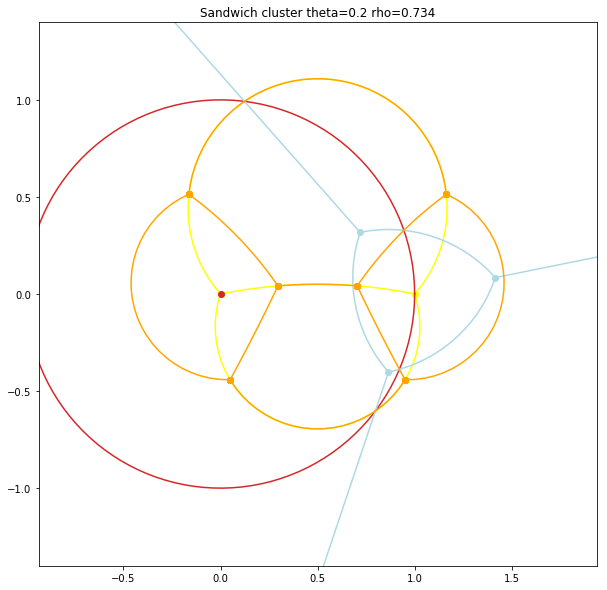

double_bubble areas: [1.2086403432377248, 0.64423082124749853]
sandwich areas: [0.98596910713294783, 0.47740727409114103, 0.47740727409270267, 0.47740727409270323]
sandwich curvatures: [0.39733866159012382, 1.4988557768261277, 1.896194438416249, 0.50512197491338939, 0.10778331332326796, 0.50512197491338873, 0.10778331332326958, 2.0039777517395181, 2.0039777517395181]


In [7]:
"""
Plot a picture for a given value of theta
"""
theta=0.2  # theta=0 currently is not working (because of straight edges)
rho = compute_rho(theta)

double_bubble = DoubleBubble(theta=theta)

sandwich = Sandwich(theta=theta, rho=rho)

plt.figure(figsize=(10, 10))

double_bubble.draw(plt, color="yellow")  # draw double bubble
if True: # draw inversion circle
    plt.plot(*my_arc(O, 1), "C3")
    plt.plot(*my_points(O), "C3o")
sandwich.draw_inverted(plt, color="lightblue")  # draw inverted triangle
sandwich.draw(plt, color="orange")  # draw sandwich cluster

plt.axis('equal')
L = 1.4
plt.axis([-L+0.5,L+0.5, -L,L])
plt.title('Sandwich cluster theta={:.3} rho={:.3}'.format(theta, rho))
plt.show()

print("double_bubble areas:", double_bubble.areas())
print("sandwich areas:", sandwich.areas())
print("sandwich curvatures:", sandwich.curvatures())

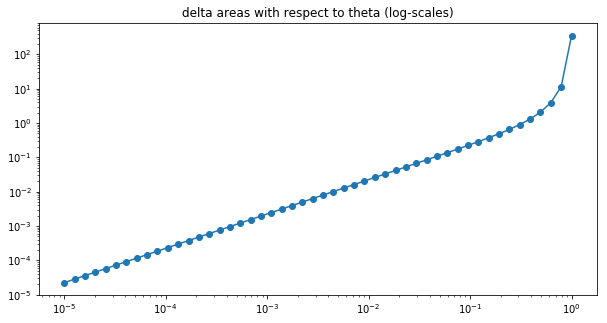

In [5]:
"""
We conjecture that the function area_delta(theta) is increasing. 
Since we know that area_delta(0)=0 this would imply that there is
no other sandwich cluster with equal areas.

To get a numerical evidence we are going to plot the function area_delta.
"""

plt.figure(figsize=(10,5))
theta = logspace(-5, 0)
delta = array(list(map(area_delta, theta)))
plt.loglog(theta, delta, "-o")
plt.title('delta areas with respect to theta (log-scales)')
plt.show()

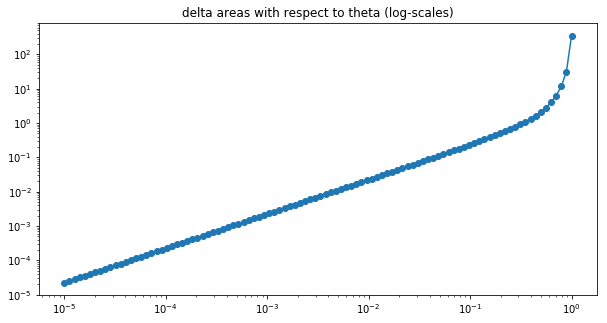

In [6]:
"""
Same plot with more points
"""
plt.figure(figsize=(10,5))
theta = logspace(-5, 0, 100)
delta = array(list(map(area_delta, theta)))
plt.loglog(theta, delta, "-o")
plt.title('delta areas with respect to theta (log-scales)')
plt.show()